In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import io
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets

from PIL import Image
from warnings import filterwarnings

from IPython.display import display, clear_output


In [2]:
labels=['Cu100','Cu200','Cu300','Cu400','Cu500','Cu600','Cu700','Cu800','Cu900','Cu1000']

In [3]:
X_train=[]
Y_train=[]

image_size=150

for i in labels:
    folderpath=os.path.join("../input/100-1000-shot-counting/100-1000_Shot/","100-1000_train",i)
    for j in tqdm(os.listdir(folderpath)):
        image=cv2.imread(os.path.join(folderpath,j))
        image=cv2.resize(image, (image_size,image_size))
        
        X_train.append(image)
        Y_train.append(i)
        

        
for i in labels:
    folderpath=os.path.join("../input/100-1000-shot-counting/100-1000_Shot/","100-1000_test",i)
    for j in tqdm(os.listdir(folderpath)):
        image=cv2.imread(os.path.join(folderpath,j))
        image=cv2.resize(image, (image_size,image_size))
        
        X_train.append(image)
        Y_train.append(i)
        
        
X_train=np.array(X_train)
Y_train=np.array(Y_train)

100%|██████████| 24/24 [00:00<00:00, 181.61it/s]


In [4]:
X_train.shape

(1320, 150, 150, 3)

In [5]:
Y_train.shape

(1320,)

In [6]:
X_train, Y_train=shuffle(X_train,Y_train,random_state=101)

In [7]:
X_train,x_test, Y_train,y_test=train_test_split(X_train, Y_train,test_size=0.1,random_state=101)

In [8]:
X_train.shape

(1188, 150, 150, 3)

In [9]:
y_test.shape

(132,)

In [10]:
y_train_new=[]
y_test_new=[]

for i in Y_train:
    y_train_new.append(labels.index(i))
    

Y_train=to_categorical(y_train_new)

for i in y_test:
    y_test_new.append(labels.index(i))
    

y_test=to_categorical(y_test_new)

In [11]:
y_test.shape

(132, 10)

In [12]:
efficient=EfficientNetB5(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))

2022-09-07 09:05:57.245298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 09:05:57.381831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 09:05:57.382714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 09:05:57.385059: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

115277824/115263384 [==============================] - 2s 0us/step


In [13]:
model=efficient.output
model=tf.keras.layers.GlobalAveragePooling2D()(model)
model=tf.keras.layers.Dropout(0.5)(model)
model=tf.keras.layers.Dense (10,activation="softmax")(model)
model=tf.keras.models.Model(inputs=efficient.input, outputs=model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [15]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
              metrics=['accuracy']
             )

In [16]:
tensorboard=TensorBoard(log_dir="logs")
checkpoint=ModelCheckpoint("efficientB5.h5",
                          monitor='val_accuracy',
                          mode="auto",
                          verbose=1,
                          save_best_only=True
                          )

reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.1,
                            patience=10,
                            min_delta=0.001,
                            mode="auto",
                            verbose=1
                           )

2022-09-07 09:06:06.820818: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-07 09:06:06.820861: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-07 09:06:06.823374: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-09-07 09:06:07.033442: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-07 09:06:07.033844: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [17]:
history=model.fit(X_train,Y_train,
                 validation_split=0.1,
                  epochs=20,
                  verbose=1,
                  batch_size=32,
                  callbacks=[tensorboard, checkpoint,reduce_LR]
                 )

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-09-07 09:06:07.765027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-07 09:06:28.687097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/34 [..............................] - ETA: 15:15 - loss: 2.4680 - accuracy: 0.1250

2022-09-07 09:06:36.195993: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-07 09:06:36.196052: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/34 [>.............................] - ETA: 42s - loss: 2.2796 - accuracy: 0.2188  

2022-09-07 09:06:36.915707: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-07 09:06:36.921230: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-07 09:06:37.121681: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5106 callback api events and 5103 activity events. 
2022-09-07 09:06:37.246134: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-07 09:06:37.419671: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_07_09_06_37

2022-09-07 09:06:37.518214: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_07_09_06_37/c63aace27c7e.trace.json.gz
2022-09-07 09:06:37.755418: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

34/34 [==============================] - 47s 569ms/step - loss: 1.0687 - accuracy: 0.5903 - val_loss: 2.9018 - val_accuracy: 0.3613

Epoch 00001: val_accuracy improved from -inf to 0.36134, saving model to efficientB5.h5
Epoch 2/20
34/34 [==============================] - 12s 360ms/step - loss: 0.5720 - accuracy: 0.7783 - val_loss: 1.6510 - val_accuracy: 0.5210

Epoch 00002: val_accuracy improved from 0.36134 to 0.52101, saving model to efficientB5.h5
Epoch 3/20
34/34 [==============================] - 12s 365ms/step - loss: 0.4258 - accuracy: 0.8653 - val_loss: 1.1538 - val_accuracy: 0.6723

Epoch 00003: val_accuracy improved from 0.52101 to 0.67227, saving model to efficientB5.h5
Epoch 4/20
34/34 [==============================] - 12s 358ms/step - loss: 0.4113 - accuracy: 0.8728 - val_loss: 0.8405 - val_accuracy: 0.8151

Epoch 00004: val_accuracy improved from 0.67227 to 0.81513, saving model to efficientB5.h5
Epoch 5/20
34/34 [==============================] - 12s 362ms/step - loss:

In [18]:
pred=model.predict(x_test)

In [19]:
model.evaluate(x_test,y_test)

5/5 [==============================] - 0s 64ms/step - loss: 0.0185 - accuracy: 0.9924


[0.018540406599640846, 0.9924242496490479]

In [20]:
pred=np.argmax(pred,axis=1)
y_test_new=np.argmax(y_test,axis=1)

In [21]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         8
           8       1.00      0.92      0.96        13
           9       0.93      1.00      0.97        14

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



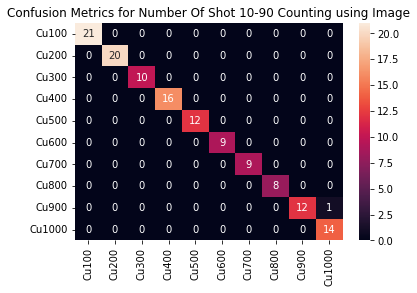

In [22]:
Cm=confusion_matrix(y_test_new,pred)
ax=plt.axes()
sns.heatmap(Cm, annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
            yticklabels=labels,
            ax=ax
           )

plt.title("Confusion Metrics for Number Of Shot 10-90 Counting using Image")
plt.show()

In [23]:
def accuracy_and_loss_Plot(modelData):
    
    fig=plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
        
    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    plt.grid()
    plt.legend()
    plt.tight_layout()

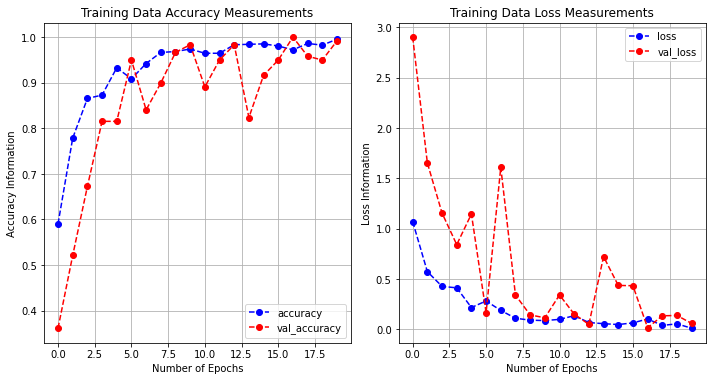

In [24]:
accuracy_and_loss_Plot(history)

In [25]:
plt.savefig("accuracy_and_loss_Plot.png")

<Figure size 432x288 with 0 Axes>

In [26]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Cu100"
    elif prd == 1:
        prd = "Cu200"
    elif prd ==2:
        prd = "Cu300"
        
    elif prd == 3:
        prd = "Cu400"
    elif prd ==4:
        prd = "Cu500"
    elif prd == 5:
        prd = "Cu600"
    elif prd ==6:
        prd = "Cu700"
    elif prd == 7:
        prd = "Cu800"
    elif prd ==8:
        prd = "Cu900"
    elif prd ==9:
        prd = "Cu1000"
     
     
    print(f'Model Predict That is  a {prd}')

In [27]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [28]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])

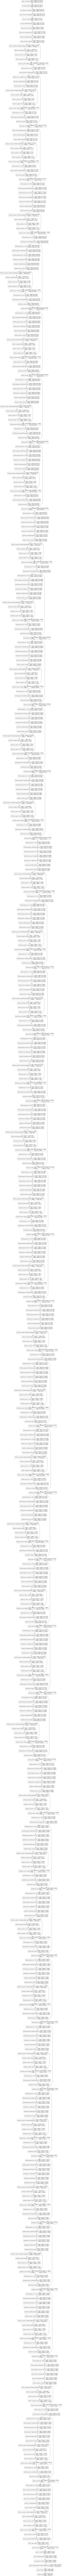

In [29]:
saved_model=tf.keras.models.load_model("./efficientB5.h5")

#show model architecture
plot_model(saved_model,
           to_file='efficientB5.png',
           show_shapes=True,
           show_layer_names=True
          )